<a href="https://colab.research.google.com/github/jjordana/twitter_sentiment_analysis/blob/master/preparingData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SENTIMENT ANALYSIS**

# ![picture](http://t-redactyl.io/figure/Vader_1.jpg)
[Jodie Burchell site's image](http://t-redactyl.io/)





# Set-Up


## Kaggle's API

In [0]:
!pip install -q kaggle
!mkdir .kaggle

In [0]:
import json
token = {"username":"jjordana16","key":"6e806145f7c3fdd4c09e7299f3a70d73"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v/content

- path is now set to: /content


In [0]:
!kaggle competitions download -c tweet-sentiment-extraction

  0% 0.00/307k [00:00<?, ?B/s]
100% 307k/307k [00:00<00:00, 94.6MB/s]
  0% 0.00/41.4k [00:00<?, ?B/s]
100% 41.4k/41.4k [00:00<00:00, 37.6MB/s]
  0% 0.00/1.23M [00:00<?, ?B/s]
100% 1.23M/1.23M [00:00<00:00, 79.2MB/s]


## Importing Libraries & data

In [0]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

import os
import re
import random
import re, string

from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer

## Used for creating the words graphs
from collections import defaultdict
import plotly.graph_objs as go
from plotly import tools
import plotly.offline as py

# Listing all the files in our folder
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import warnings
warnings.filterwarnings("ignore")

In [0]:
test = pd.read_csv('/content/competitions/tweet-sentiment-extraction/test.csv')
train = pd.read_csv('/content/competitions/tweet-sentiment-extraction/train.csv.zip')

In [124]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [174]:
train = train.dropna()
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


# EDA

Our first main target is going to be the analysis of all our tweets data. We are going to focus first on the `training set`.<br>

We have distinguish three types of sentiments: `positive`, `neutral`, and `negative`. <br> The main aim if this [Kaggle's competition](https://www.kaggle.com/c/tweet-sentiment-extraction) is to get the words that have the highest weight for deciding the sentiment of a tweet. Therefore, the sentiment has already been stablished, we do not need to get it.<br>
However, I found crucial to understand how `sentiment analysis` works before going on a further level.

In our `training data`, `neutral` tweets are the most common ones, followed by `positive`tweets. Let's try to plot which are the most common words in all these three types of text.

neutral     11118
positive     8582
negative     7781
Name: sentiment, dtype: int64


Text(0.5, 1.0, 'Train Sentiment Count')

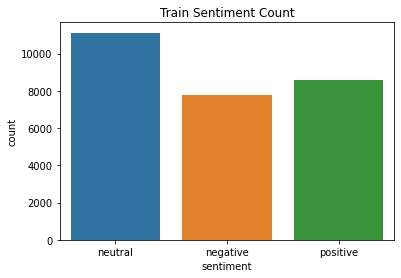

In [0]:
print(train['sentiment'].value_counts())
sns.countplot(x='sentiment', data=train).set_title('Train Sentiment Count')

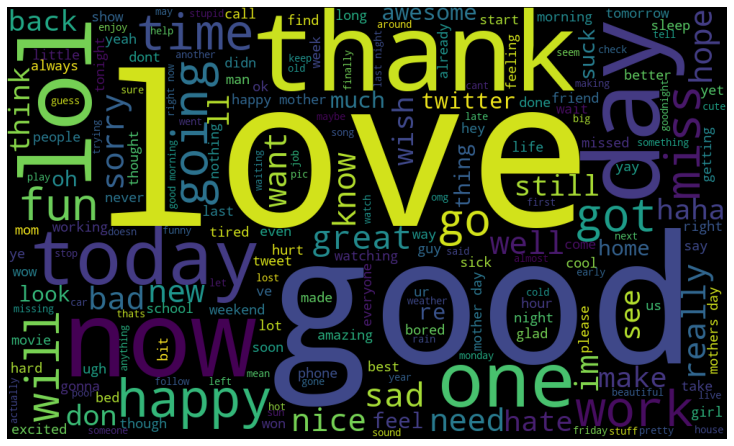

In [0]:
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in train['selected_text']: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 1000, height = 600, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

Words such as _love, good, thank_ seem to be the most common in all our data. However, trying to plot a `worcloud` with all the *selected_text* is useless. It is more acurrate to work separetly with all the different sentiments. 

We can split our oirginal dataste into three subdatasets, differentiated by the sentiment. <br> After having all the data splitted we can now study sentiment by sentiment.

NPL processes deal with text chains. This chains need to be trasnformed. <br> Firstly, we are going to split our tweets into `tokens`, sets of words. After this, `lemmatization`much be the following step. In this part, we will get the root of the word _(i.e the root for **player** is play)_.

But, before performing any of these steps, we must **clean** firstly our data. I consider this part the most important one. <br> Keep in mind that we are dealing with **tweets**!! Here anyone can write in any particular way. There are no rules. For sure our texts are full of special character [?!,:),:(&], links and so on. We need to try to homogenize our data as much as possible.<br><br>
Besides, we are going to try to solve those imperfections such as _heeeeello_. Here, you can see that the letter **e** is repeated several times. Although we know that means __hello__, the code is going to treat it as a different word. We will try to fix this by trying to replace any `vocal` or common letter (i.e `n, r, s, l`) that is repeated more than three time.


In [0]:
train['newText'] = train['text'].str.lower()

In [0]:
def cleaningText(df, column):
  # Removing special characters
  for val in map(lambda r: re.compile(re.escape(r)), [",", ":", "\"", "=", "&", ";", "%", "$",
                                                                      "@", "%", "^", "*", "(", ")", "{", "}",
                                                                      "[", "]", "|", "/", "\\", ">", "<", "-",
                                                                      "!", "?", ".", "'", "_",
                                                                      "--", "---", "#"]):
    df[column] = df[column].str.replace(re.compile(val), "")

  # Removing urls
  df[column] = df[column].replace('http\S[a-z0-9]+', '', regex=True)

  return df

In [0]:
 # Removing repeated letters
def control(x):
    text = x
    #for letter in ['a', 'e', 'i', 'o', 'u', 'r', 'l', 'n', 's', 'm']:
    for letter in ['e', 'l', 'o']:
        key = str(letter*3) + '+'
        if len(re.findall(key, text)) > 0:
            text = re.sub((str(letter*3) + '+'), letter, text)
        
    return text
  

In [0]:
alpha['newText'] = alpha['newText'].apply(control)

In [180]:
alpha

,textID,text,selected_text,sentiment,newText
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,i`d have responded if i were going
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,so sad i will miss you here in san diego
2,088c60f138,my boss is bullying me...,bullying me,negative,my boss is bullying me
3,9642c003ef,what interview! leave me alone,leave me alone,negative,what interview leave me alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,sons of why couldn`t they put them on the re...
...,...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative,wish we could come see u on denver husband l...
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative,i`ve wondered about rake to the client has m...
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,yay good for both of you enjoy the break you...
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive,but it was worth it


In [176]:
train = cleaningText(train, 'newText')
train

,textID,text,selected_text,sentiment,newText
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,i`d have responded if i were going
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,sooo sad i will miss you here in san diego
2,088c60f138,my boss is bullying me...,bullying me,negative,my boss is bullying me
3,9642c003ef,what interview! leave me alone,leave me alone,negative,what interview leave me alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,sons of why couldn`t they put them on the re...
...,...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative,wish we could come see u on denver husband l...
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative,i`ve wondered about rake to the client has m...
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,yay good for both of you enjoy the break you...
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive,but it was worth it


In [0]:
# One dataset for each sentiment
positive = train[train['sentiment'] == 'positive']
neutral = train[train['sentiment'] == 'neutral']
negative = train[train['sentiment'] == 'negative']

In [0]:
def tokenization(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != ""]
    myToken = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(val) for val in myToken]

lemmatizer = WordNetLemmatizer()

def lemmatization(tokens):
    lemmatized_words = []
    for val in tokens:
        val = lemmatizer.lemmatize(val,pos ="a")
        val = lemmatizer.lemmatize(val,pos ="n")
        val = lemmatizer.lemmatize(val,pos ="v")
        lemmatized_words.append(val)
    return lemmatized_words

In [0]:
def tokenization(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != ""]
    myToken = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(val) for val in myToken]

lemmatizer = WordNetLemmatizer()

def lemmatization(tokens):
    lemmatized_words = []
    for val in tokens:
        val = lemmatizer.lemmatize(val,pos ="a")
        val = lemmatizer.lemmatize(val,pos ="n")
        val = lemmatizer.lemmatize(val,pos ="v")
        lemmatized_words.append(val)
    return lemmatized_words

In [0]:
def a(df):
  comment_words = '' 
  stopwords = set(STOPWORDS) 
    
  # iterate through the csv file 
  for val in train['selected_text']: 
        
      # typecaste each val to string 
      val = str(val) 
    
      # split the value 
      tokens = val.split() 
        
      # Converts each token into lowercase 
      for i in range(len(tokens)): 
          tokens[i] = tokens[i].lower() 
        
      comment_words += " ".join(tokens)+" "

  wordcloud = WordCloud(width = 800, height = 800, 
                  background_color ='black', 
                  stopwords = stopwords, 
                  min_font_size = 10).generate(comment_words) 
  
  return wordcloud

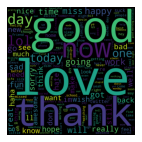

In [0]:
fig = plt.figure(figsize = (8, 8), facecolor = None)
for val in ['positive', 'neutral', 'negative']:
    ax = fig.add_subplot(3, 3,1)
    wordcloud = a(train[train['sentiment']==val]['selected_text'])

    ax.imshow(wordcloud)
    ax.axis("off") 
    plt.show()

In [0]:
train[train['sentiment']=='positive']['selected_text']

6                                                      fun
9                             Wow... u just became cooler.
11                                                    like
21                                            interesting.
25       the free fillin` app on my ipod is fun, im add...
                               ...                        
27467                                              welcome
27474                                       I feel good ab
27475                                                enjoy
27478                            Yay good for both of you.
27479                           But it was worth it  ****.
Name: selected_text, Length: 8582, dtype: object

In [0]:
! pip install matplotlib-venn-wordcloud


AttributeError: ignored

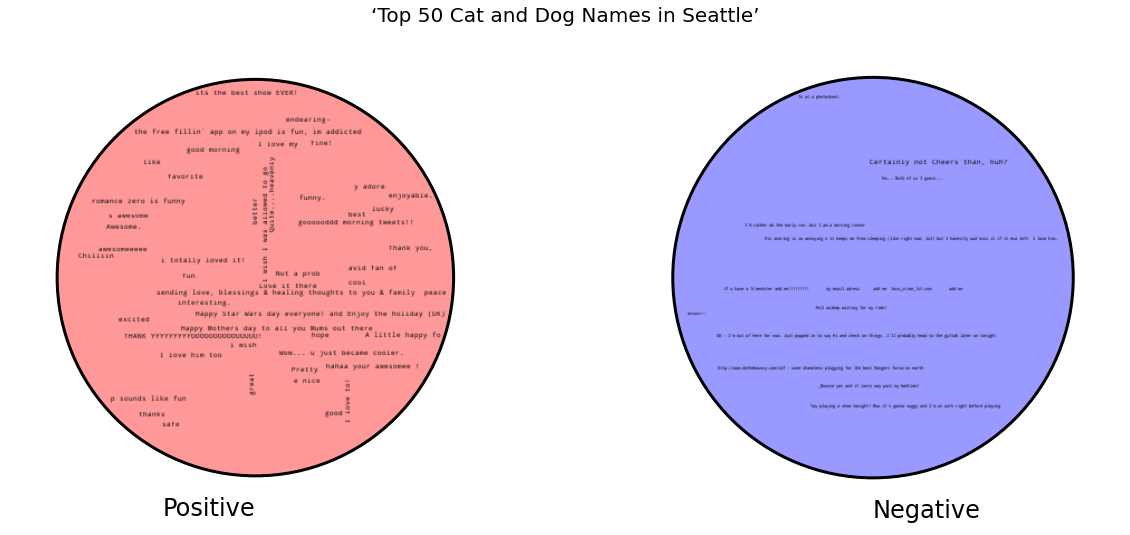

In [0]:
#https://towardsdatascience.com/venn-diagrams-and-word-clouds-in-python-1012373b38ed

from matplotlib_venn import venn2, venn2_circles
from matplotlib_venn_wordcloud import venn2_wordcloud

fig, ax = plt.subplots(figsize=(20,20))
ax.set_title("‘Top 50 Cat and Dog Names in Seattle’", fontsize=20)
v = venn2_wordcloud([set(train[train['sentiment']=='positive']['selected_text'].head(50)), set(train[train['sentiment']=='neutral']['selected_text'].head(50))],
                    ax=ax, set_labels=['Positive', 'Negative'])
# add color
v.get_patch_by_id('10').set_color('red')
v.get_patch_by_id('10').set_alpha(0.4)
v.get_patch_by_id('01').set_color('blue')
v.get_patch_by_id('01').set_alpha(0.4)
v.get_patch_by_id('11').set_color('purple')
v.get_patch_by_id('11').set_alpha(0.4)